In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Input, Activation, Dropout, Add, LSTM, GRU, RNN, LayerNormalization, BatchNormalization, Conv1D, MaxPooling1D, Flatten, Layer
from keras import backend as K
from keras.optimizers import Adam,SGD
import tensorflow as tf
from keras import Model, regularizers, activations
from keras.constraints import Constraint
import pickle

In [2]:
# specifying constant parameters

T_0 = 300
V = 1
k_0 = 8.46*(np.power(10,6))
C_p = 0.231
rho_L = 1000
Q_s = 0.0
T_s = 401.8727
F = 5
E = 5*(np.power(10,4))
delta_H = -1.15*(np.power(10,4))
R = 8.314
C_A0s = 4
C_As = 1.9537
t_final = 0.005
t_step = 1e-4
P = np.array([[1060, 22], [22, 0.52]])

num_step = 10

In [3]:
# generating inputs and initial states for CSTR, all expressed in deviation form

u1_list = np.linspace(-3.5, 3.5, 4, endpoint=True)
u2_list = np.linspace(-5e5, 5e5, 4, endpoint=True)
T_initial = np.linspace(300, 600, 100, endpoint=True) - T_s
CA_initial = np.linspace(0, 6, 100, endpoint=True) - C_As

In [4]:
# sieve out initial states that lie outside of stability region

T_start = list()
CA_start = list()

for T in T_initial:
    for CA in CA_initial:
        x = np.array([CA, T])
        if x @ P @ x < 372:
            CA_start.append(CA)
            T_start.append(T)
print("number of initial conditions: {}".format(len(CA_start)))

# convert to np.arrays
CA_start = np.array([CA_start])
T_start = np.array([T_start])
x_deviation = np.concatenate((CA_start.T, T_start.T), axis=1)  # every row is a pair of initial states within stability region
print("shape of x_deviation is {}".format(x_deviation.shape))

number of initial conditions: 772
shape of x_deviation is (772, 2)


In [5]:
def CSTR_simulation(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial):
    """
        simulating CSTR using forward Euler method
    """

    C_A_list = list()  # evolution of CA over time
    T_list = list()  # evolution of T over time

    C_A = C_A_initial + C_As
    T = T_initial + T_s

    for i in range(int(t_final / t_step)):
        dCAdt = F / V * (C_A0 - C_A) - k_0 * np.exp(-E / (R * T)) * C_A**2
        dTdt = F / V * (T_0 - T) - delta_H / (rho_L * C_p) * k_0 * np.exp(-E / (R * T)) * C_A**2 + Q / (rho_L * C_p * V)

        T += dTdt * t_step
        C_A += dCAdt * t_step

        if i % 5 == 0:
          C_A_list.append(C_A - C_As)  # in deviation form
          T_list.append(T - T_s)  # in deviation form

    return C_A_list, T_list

In [6]:
# get X and y data for training and testing

CA_output = list()
T_output = list()
CA_input = list()
T_input = list()
CA0_input = list()
Q_input = list()

for u1 in u1_list:
    C_A0 = u1 + C_A0s

    for u2 in u2_list:
        Q = u2 + Q_s

        for C_A_initial, T_initial in x_deviation:
            CA0_input.append(u1)
            Q_input.append(u2)
            CA_input.append(C_A_initial)
            T_input.append(T_initial)

            C_A_list, T_list = CSTR_simulation(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial)
            CA_output.append(C_A_list)
            T_output.append(T_list)

In [7]:
CA0_input = np.array(CA0_input)
print(CA0_input.shape)
CA_output = np.array(CA_output)
print(CA_output.shape)

(12352,)
(12352, 10)


In [8]:
# collate input for RNN

CA0_input = np.array(CA0_input)
CA0_input = CA0_input.reshape(-1,1,1)

Q_input = np.array(Q_input)
Q_input = Q_input.reshape(-1,1,1)

CA_input = np.array(CA_input)
CA_input = CA_input.reshape(-1,1,1)

T_input = np.array(T_input)
T_input = T_input.reshape(-1,1,1)

CA0_input_neg = -np.array(CA0_input)
CA0_input_neg = CA0_input_neg.reshape(-1,1,1)

Q_input_neg = -np.array(Q_input)
Q_input_neg = Q_input_neg.reshape(-1,1,1)

CA_input_neg = -np.array(CA_input)
CA_input_neg = CA_input_neg.reshape(-1,1,1)

T_input_neg = -np.array(T_input)
T_input_neg = T_input_neg.reshape(-1,1,1)

RNN_input = np.concatenate((T_input, CA_input, Q_input, CA0_input, T_input_neg, CA_input_neg, Q_input_neg, CA0_input_neg), axis=2)

"""
    the input to RNN is in the shape [number of samples x timestep x variables], and the input variables are same for every
    time step, not sure if my treatment here is correct
"""

RNN_input = RNN_input.repeat(num_step, axis=1)
print("RNN_input shape is {}".format(RNN_input.shape))

RNN_input shape is (12352, 10, 8)


In [9]:
# checking the input is duplicated 100 times for each time step
print(RNN_input[0, 0])
print(RNN_input[0, 1])

[-7.45999727e+01  1.44023939e+00 -5.00000000e+05 -3.50000000e+00
  7.45999727e+01 -1.44023939e+00  5.00000000e+05  3.50000000e+00]
[-7.45999727e+01  1.44023939e+00 -5.00000000e+05 -3.50000000e+00
  7.45999727e+01 -1.44023939e+00  5.00000000e+05  3.50000000e+00]


In [10]:
# collate output for RNN

CA_output = np.array(CA_output)
CA_output = CA_output.reshape(-1, num_step, 1)

T_output = np.array(T_output)
T_output = T_output.reshape(-1, num_step, 1)

RNN_output = np.concatenate((T_output, CA_output), axis=2)
print("RNN_output shape is {}".format(RNN_output.shape))  # output shape: number of samples x timestep x variables

RNN_output shape is (12352, 10, 2)


In [11]:
# checking output
print(RNN_output[0, :5])

[[-74.82498608   1.43869052]
 [-75.94937347   1.43097798]
 [-77.07255531   1.4233169 ]
 [-78.19443649   1.41570516]
 [-79.31492759   1.4081408 ]]


In [12]:
tf.random.set_seed(42)

class MyRNNCell(tf.keras.layers.Layer):

    def __init__(self, units, input_shape_custom, **kwargs):
        self.units = units
        self.input_shape_custom = input_shape_custom
        self.state_size = [tf.TensorShape([units]), tf.TensorShape([input_shape_custom])]
        super(MyRNNCell, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      initializer='uniform',
                                      name='kernel',
                                      constraint=tf.keras.constraints.NonNeg(),
                                      trainable=True)
        self.recurrent_kernel = self.add_weight(shape=(self.units, self.units),
                                                initializer='uniform',
                                                name='recurrent_kernel',
                                                constraint=tf.keras.constraints.NonNeg(),
                                                trainable=True)
        self.D1 = self.add_weight(shape=(self.units, self.units),
                                 initializer='uniform',
                                 name='D1',
                                 constraint=tf.keras.constraints.NonNeg(),
                                 trainable=True)
        self.D2 = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='uniform',
                                 name='D2',
                                 constraint=tf.keras.constraints.NonNeg(),
                                 trainable=True)
        self.D3 = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='uniform',
                                 name='D3',
                                 constraint=tf.keras.constraints.NonNeg(),
                                 trainable=True)
        self.V = self.add_weight(shape=(self.units, self.units),
                                 initializer='uniform',
                                 name='V',
                                 constraint=tf.keras.constraints.NonNeg(),
                                 trainable=True)
        self.built = True

    def call(self, inputs, states):
        # ICRNN
        prev_h, prev_input = states
        h = K.dot(inputs, self.kernel) + K.dot(prev_h, self.recurrent_kernel) + K.dot(prev_input, self.D2)
        h = tf.nn.relu(h)
        y = K.dot(h, self.V) + K.dot(prev_h, self.D1) + K.dot(inputs, self.D3)
        y = tf.nn.relu(y)
        return y, [h, inputs]

    def get_config(self):
        config = super(MyRNNCell, self).get_config()
        config.update({"units": self.units, "input_shape_custom": self.input_shape_custom})
        return config

In [13]:
# set the seed for reproducibility
tf.random.set_seed(42)

training_loss = [0]*10
test_loss = [0]*10
noise = 0
for i in range(10):
  num_dims = 8

  # split into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(RNN_input, RNN_output, test_size=0.3, random_state=123)

  # # define scalers for both X and y base on training data only
  scaler_X = preprocessing.StandardScaler().fit(X_train.reshape(-1, num_dims))
  scaler_y = preprocessing.StandardScaler().fit(y_train.reshape(-1, 2))

  X_train = scaler_X.transform(X_train.reshape(-1, num_dims)).reshape(-1,num_step,num_dims)
  X_test = scaler_X.transform(X_test.reshape(-1, num_dims)).reshape(-1,num_step,num_dims)
  y_train = scaler_y.transform(y_train.reshape(-1,2)).reshape(-1,num_step,2)
  y_test_normalized = scaler_y.transform(y_test.reshape(-1,2)).reshape(-1,num_step,2)

  y_train = y_train + np.random.normal(0, noise, y_train.shape)

  model = Sequential()
  model.add(RNN(MyRNNCell(units=512, input_shape_custom=X_train.shape[2]),return_sequences=True))
  model.add(RNN(MyRNNCell(units=512, input_shape_custom=512),return_sequences=True))
  model.add(Dense(2, activation='linear'))

  model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])
  history = model.fit(X_train, y_train, epochs=200, batch_size=256, validation_split=0.25, verbose=2)
  training_loss[i] = history.history['val_loss'][-1]
  print(noise)
  print(training_loss)

  loss = model.evaluate(X_test, y_test_normalized, batch_size=256)
  test_loss[i] = loss[0]
  print(test_loss)

  name = 'icrnn_512_'
  name = name + str(noise) + '.h5'
  model.save(name)

  noise = noise + 0.1

model.summary()

Epoch 1/200
26/26 - 12s - loss: 52565439015813120.0000 - mean_squared_error: 52565430425878528.0000 - val_loss: 1287823529345024.0000 - val_mean_squared_error: 1287823663562752.0000 - 12s/epoch - 478ms/step
Epoch 2/200
26/26 - 7s - loss: 651684111974400.0000 - mean_squared_error: 651683977756672.0000 - val_loss: 374644192313344.0000 - val_mean_squared_error: 374644192313344.0000 - 7s/epoch - 253ms/step
Epoch 3/200
26/26 - 6s - loss: 317563338752000.0000 - mean_squared_error: 317563305197568.0000 - val_loss: 272570402209792.0000 - val_mean_squared_error: 272570385432576.0000 - 6s/epoch - 250ms/step
Epoch 4/200
26/26 - 6s - loss: 246622357291008.0000 - mean_squared_error: 246622357291008.0000 - val_loss: 220822673293312.0000 - val_mean_squared_error: 220822690070528.0000 - 6s/epoch - 249ms/step
Epoch 5/200
26/26 - 7s - loss: 202309032214528.0000 - mean_squared_error: 202309048991744.0000 - val_loss: 183133546741760.0000 - val_mean_squared_error: 183133546741760.0000 - 7s/epoch - 252ms/st

Epoch 43/200
26/26 - 6s - loss: 9439052562432.0000 - mean_squared_error: 9439055708160.0000 - val_loss: 9224045199360.0000 - val_mean_squared_error: 9224044150784.0000 - 6s/epoch - 245ms/step
Epoch 44/200
26/26 - 6s - loss: 9051660353536.0000 - mean_squared_error: 9051660353536.0000 - val_loss: 8848906649600.0000 - val_mean_squared_error: 8848906649600.0000 - 6s/epoch - 242ms/step
Epoch 45/200
26/26 - 6s - loss: 8684458999808.0000 - mean_squared_error: 8684460572672.0000 - val_loss: 8494335918080.0000 - val_mean_squared_error: 8494336966656.0000 - 6s/epoch - 244ms/step
Epoch 46/200
26/26 - 6s - loss: 8339817758720.0000 - mean_squared_error: 8339819331584.0000 - val_loss: 8159250874368.0000 - val_mean_squared_error: 8159249825792.0000 - 6s/epoch - 241ms/step
Epoch 47/200
26/26 - 6s - loss: 8012570820608.0000 - mean_squared_error: 8012570296320.0000 - val_loss: 7843765288960.0000 - val_mean_squared_error: 7843765813248.0000 - 6s/epoch - 243ms/step
Epoch 48/200
26/26 - 6s - loss: 77045851

Epoch 86/200
26/26 - 6s - loss: 2377705848832.0000 - mean_squared_error: 2377705848832.0000 - val_loss: 2345398960128.0000 - val_mean_squared_error: 2345399222272.0000 - 6s/epoch - 248ms/step
Epoch 87/200
26/26 - 6s - loss: 2317881442304.0000 - mean_squared_error: 2317881442304.0000 - val_loss: 2286709637120.0000 - val_mean_squared_error: 2286709637120.0000 - 6s/epoch - 245ms/step
Epoch 88/200
26/26 - 6s - loss: 2260221820928.0000 - mean_squared_error: 2260221558784.0000 - val_loss: 2230231236608.0000 - val_mean_squared_error: 2230230974464.0000 - 6s/epoch - 245ms/step
Epoch 89/200
26/26 - 6s - loss: 2204664332288.0000 - mean_squared_error: 2204664332288.0000 - val_loss: 2174915969024.0000 - val_mean_squared_error: 2174915837952.0000 - 6s/epoch - 244ms/step
Epoch 90/200
26/26 - 6s - loss: 2150515736576.0000 - mean_squared_error: 2150516129792.0000 - val_loss: 2122053058560.0000 - val_mean_squared_error: 2122052927488.0000 - 6s/epoch - 244ms/step
Epoch 91/200
26/26 - 6s - loss: 20979740

Epoch 129/200
26/26 - 6s - loss: 907122638848.0000 - mean_squared_error: 907122704384.0000 - val_loss: 897757085696.0000 - val_mean_squared_error: 897757020160.0000 - 6s/epoch - 244ms/step
Epoch 130/200
26/26 - 6s - loss: 889159352320.0000 - mean_squared_error: 889159286784.0000 - val_loss: 879908028416.0000 - val_mean_squared_error: 879908093952.0000 - 6s/epoch - 242ms/step
Epoch 131/200
26/26 - 6s - loss: 871559593984.0000 - mean_squared_error: 871559397376.0000 - val_loss: 862455922688.0000 - val_mean_squared_error: 862455922688.0000 - 6s/epoch - 245ms/step
Epoch 132/200
26/26 - 6s - loss: 854354296832.0000 - mean_squared_error: 854354165760.0000 - val_loss: 845612318720.0000 - val_mean_squared_error: 845612384256.0000 - 6s/epoch - 242ms/step
Epoch 133/200
26/26 - 6s - loss: 837587042304.0000 - mean_squared_error: 837587173376.0000 - val_loss: 829089382400.0000 - val_mean_squared_error: 829089382400.0000 - 6s/epoch - 243ms/step
Epoch 134/200
26/26 - 6s - loss: 821291843584.0000 - me

Epoch 173/200
26/26 - 6s - loss: 398537818112.0000 - mean_squared_error: 398537785344.0000 - val_loss: 394961649664.0000 - val_mean_squared_error: 394961649664.0000 - 6s/epoch - 238ms/step
Epoch 174/200
26/26 - 6s - loss: 391555547136.0000 - mean_squared_error: 391555481600.0000 - val_loss: 388038098944.0000 - val_mean_squared_error: 388038066176.0000 - 6s/epoch - 238ms/step
Epoch 175/200
26/26 - 6s - loss: 384752910336.0000 - mean_squared_error: 384752975872.0000 - val_loss: 381306535936.0000 - val_mean_squared_error: 381306535936.0000 - 6s/epoch - 239ms/step
Epoch 176/200
26/26 - 6s - loss: 378079117312.0000 - mean_squared_error: 378079150080.0000 - val_loss: 374740320256.0000 - val_mean_squared_error: 374740353024.0000 - 6s/epoch - 238ms/step
Epoch 177/200
26/26 - 6s - loss: 371538558976.0000 - mean_squared_error: 371538591744.0000 - val_loss: 368270802944.0000 - val_mean_squared_error: 368270802944.0000 - 6s/epoch - 238ms/step
Epoch 178/200
26/26 - 6s - loss: 365100007424.0000 - me

C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/200
26/26 - 12s - loss: 15569227456970752.0000 - mean_squared_error: 15569224235745280.0000 - val_loss: 47337250488320.0000 - val_mean_squared_error: 47337250488320.0000 - 12s/epoch - 475ms/step
Epoch 2/200
26/26 - 6s - loss: 24034930589696.0000 - mean_squared_error: 24034928492544.0000 - val_loss: 15393100922880.0000 - val_mean_squared_error: 15393100922880.0000 - 6s/epoch - 248ms/step
Epoch 3/200
26/26 - 6s - loss: 13968620912640.0000 - mean_squared_error: 13968621961216.0000 - val_loss: 13193565962240.0000 - val_mean_squared_error: 13193564913664.0000 - 6s/epoch - 246ms/step
Epoch 4/200
26/26 - 6s - loss: 12634089848832.0000 - mean_squared_error: 12634090897408.0000 - val_loss: 12237780549632.0000 - val_mean_squared_error: 12237779501056.0000 - 6s/epoch - 246ms/step
Epoch 5/200
26/26 - 6s - loss: 11773720657920.0000 - mean_squared_error: 11773721706496.0000 - val_loss: 11399699890176.0000 - val_mean_squared_error: 11399700938752.0000 - 6s/epoch - 246ms/step
Epoch 6/200
26/26

Epoch 44/200
26/26 - 7s - loss: 1331921944576.0000 - mean_squared_error: 1331921944576.0000 - val_loss: 1301356347392.0000 - val_mean_squared_error: 1301356347392.0000 - 7s/epoch - 250ms/step
Epoch 45/200
26/26 - 7s - loss: 1277546987520.0000 - mean_squared_error: 1277546987520.0000 - val_loss: 1248708657152.0000 - val_mean_squared_error: 1248708526080.0000 - 7s/epoch - 251ms/step
Epoch 46/200
26/26 - 6s - loss: 1226112761856.0000 - mean_squared_error: 1226112630784.0000 - val_loss: 1198508998656.0000 - val_mean_squared_error: 1198508998656.0000 - 6s/epoch - 250ms/step
Epoch 47/200
26/26 - 7s - loss: 1177029967872.0000 - mean_squared_error: 1177029967872.0000 - val_loss: 1150977703936.0000 - val_mean_squared_error: 1150977703936.0000 - 7s/epoch - 253ms/step
Epoch 48/200
26/26 - 6s - loss: 1130464411648.0000 - mean_squared_error: 1130464280576.0000 - val_loss: 1105593368576.0000 - val_mean_squared_error: 1105593368576.0000 - 6s/epoch - 249ms/step
Epoch 49/200
26/26 - 6s - loss: 10860921

Epoch 88/200
26/26 - 6s - loss: 267818139648.0000 - mean_squared_error: 267818139648.0000 - val_loss: 262958284800.0000 - val_mean_squared_error: 262958284800.0000 - 6s/epoch - 249ms/step
Epoch 89/200
26/26 - 6s - loss: 258833530880.0000 - mean_squared_error: 258833514496.0000 - val_loss: 254116298752.0000 - val_mean_squared_error: 254116298752.0000 - 6s/epoch - 248ms/step
Epoch 90/200
26/26 - 6s - loss: 250125959168.0000 - mean_squared_error: 250125942784.0000 - val_loss: 245567520768.0000 - val_mean_squared_error: 245567537152.0000 - 6s/epoch - 246ms/step
Epoch 91/200
26/26 - 6s - loss: 241703829504.0000 - mean_squared_error: 241703829504.0000 - val_loss: 237324156928.0000 - val_mean_squared_error: 237324140544.0000 - 6s/epoch - 248ms/step
Epoch 92/200
26/26 - 6s - loss: 233593044992.0000 - mean_squared_error: 233593044992.0000 - val_loss: 229295636480.0000 - val_mean_squared_error: 229295636480.0000 - 6s/epoch - 247ms/step
Epoch 93/200
26/26 - 6s - loss: 225703870464.0000 - mean_squ

Epoch 132/200
26/26 - 6s - loss: 53876310016.0000 - mean_squared_error: 53876301824.0000 - val_loss: 52722274304.0000 - val_mean_squared_error: 52722274304.0000 - 6s/epoch - 245ms/step
Epoch 133/200
26/26 - 6s - loss: 51711619072.0000 - mean_squared_error: 51711614976.0000 - val_loss: 50604134400.0000 - val_mean_squared_error: 50604138496.0000 - 6s/epoch - 246ms/step
Epoch 134/200
26/26 - 6s - loss: 49624805376.0000 - mean_squared_error: 49624805376.0000 - val_loss: 48543551488.0000 - val_mean_squared_error: 48543547392.0000 - 6s/epoch - 246ms/step
Epoch 135/200
26/26 - 6s - loss: 47599788032.0000 - mean_squared_error: 47599796224.0000 - val_loss: 46562754560.0000 - val_mean_squared_error: 46562750464.0000 - 6s/epoch - 245ms/step
Epoch 136/200
26/26 - 6s - loss: 45645103104.0000 - mean_squared_error: 45645103104.0000 - val_loss: 44644896768.0000 - val_mean_squared_error: 44644896768.0000 - 6s/epoch - 246ms/step
Epoch 137/200
26/26 - 6s - loss: 43759161344.0000 - mean_squared_error: 437

Epoch 177/200
26/26 - 6s - loss: 5477623808.0000 - mean_squared_error: 5477623808.0000 - val_loss: 5293478400.0000 - val_mean_squared_error: 5293478400.0000 - 6s/epoch - 248ms/step
Epoch 178/200
26/26 - 6s - loss: 5134266880.0000 - mean_squared_error: 5134267392.0000 - val_loss: 4959742464.0000 - val_mean_squared_error: 4959742464.0000 - 6s/epoch - 244ms/step
Epoch 179/200
26/26 - 6s - loss: 4809262592.0000 - mean_squared_error: 4809262592.0000 - val_loss: 4644313088.0000 - val_mean_squared_error: 4644312576.0000 - 6s/epoch - 244ms/step
Epoch 180/200
26/26 - 6s - loss: 4501723648.0000 - mean_squared_error: 4501723136.0000 - val_loss: 4344681984.0000 - val_mean_squared_error: 4344681984.0000 - 6s/epoch - 247ms/step
Epoch 181/200
26/26 - 6s - loss: 4209479168.0000 - mean_squared_error: 4209479680.0000 - val_loss: 4061136640.0000 - val_mean_squared_error: 4061136128.0000 - 6s/epoch - 249ms/step
Epoch 182/200
26/26 - 7s - loss: 3933286144.0000 - mean_squared_error: 3933285888.0000 - val_lo

C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/200
26/26 - 12s - loss: 11678435910877184.0000 - mean_squared_error: 11678435910877184.0000 - val_loss: 6356390641664.0000 - val_mean_squared_error: 6356390641664.0000 - 12s/epoch - 468ms/step
Epoch 2/200
26/26 - 6s - loss: 2971552448512.0000 - mean_squared_error: 2971552186368.0000 - val_loss: 1798175588352.0000 - val_mean_squared_error: 1798175326208.0000 - 6s/epoch - 241ms/step
Epoch 3/200
26/26 - 6s - loss: 1644190367744.0000 - mean_squared_error: 1644190236672.0000 - val_loss: 1572225155072.0000 - val_mean_squared_error: 1572225024000.0000 - 6s/epoch - 245ms/step
Epoch 4/200
26/26 - 6s - loss: 1527899226112.0000 - mean_squared_error: 1527899226112.0000 - val_loss: 1506157920256.0000 - val_mean_squared_error: 1506158051328.0000 - 6s/epoch - 245ms/step
Epoch 5/200
26/26 - 6s - loss: 1468598845440.0000 - mean_squared_error: 1468598714368.0000 - val_loss: 1448249131008.0000 - val_mean_squared_error: 1448249262080.0000 - 6s/epoch - 243ms/step
Epoch 6/200
26/26 - 6s - loss: 1410

Epoch 45/200
26/26 - 6s - loss: 142072578048.0000 - mean_squared_error: 142072610816.0000 - val_loss: 137659826176.0000 - val_mean_squared_error: 137659842560.0000 - 6s/epoch - 244ms/step
Epoch 46/200
26/26 - 6s - loss: 133251276800.0000 - mean_squared_error: 133251268608.0000 - val_loss: 129051058176.0000 - val_mean_squared_error: 129051066368.0000 - 6s/epoch - 241ms/step
Epoch 47/200
26/26 - 6s - loss: 124909387776.0000 - mean_squared_error: 124909379584.0000 - val_loss: 120967643136.0000 - val_mean_squared_error: 120967643136.0000 - 6s/epoch - 242ms/step
Epoch 48/200
26/26 - 6s - loss: 117059739648.0000 - mean_squared_error: 117059756032.0000 - val_loss: 113336508416.0000 - val_mean_squared_error: 113336516608.0000 - 6s/epoch - 241ms/step
Epoch 49/200
26/26 - 6s - loss: 109655367680.0000 - mean_squared_error: 109655367680.0000 - val_loss: 106117283840.0000 - val_mean_squared_error: 106117292032.0000 - 6s/epoch - 242ms/step
Epoch 50/200
26/26 - 6s - loss: 102664863744.0000 - mean_squ

Epoch 90/200
26/26 - 6s - loss: 3757656576.0000 - mean_squared_error: 3757656832.0000 - val_loss: 3556515328.0000 - val_mean_squared_error: 3556515584.0000 - 6s/epoch - 222ms/step
Epoch 91/200
26/26 - 6s - loss: 3377030656.0000 - mean_squared_error: 3377031168.0000 - val_loss: 3194317056.0000 - val_mean_squared_error: 3194317568.0000 - 6s/epoch - 220ms/step
Epoch 92/200
26/26 - 6s - loss: 3031018240.0000 - mean_squared_error: 3031018240.0000 - val_loss: 2861760768.0000 - val_mean_squared_error: 2861761024.0000 - 6s/epoch - 215ms/step
Epoch 93/200
26/26 - 6s - loss: 2713260032.0000 - mean_squared_error: 2713259776.0000 - val_loss: 2561800448.0000 - val_mean_squared_error: 2561800448.0000 - 6s/epoch - 218ms/step
Epoch 94/200
26/26 - 6s - loss: 2426364416.0000 - mean_squared_error: 2426364416.0000 - val_loss: 2288138752.0000 - val_mean_squared_error: 2288139008.0000 - 6s/epoch - 219ms/step
Epoch 95/200
26/26 - 6s - loss: 2166540544.0000 - mean_squared_error: 2166540800.0000 - val_loss: 20

Epoch 137/200
26/26 - 6s - loss: 3228151.2500 - mean_squared_error: 3228150.2500 - val_loss: 2917014.5000 - val_mean_squared_error: 2917015.0000 - 6s/epoch - 219ms/step
Epoch 138/200
26/26 - 6s - loss: 2655207.0000 - mean_squared_error: 2655206.7500 - val_loss: 2396976.0000 - val_mean_squared_error: 2396976.0000 - 6s/epoch - 215ms/step
Epoch 139/200
26/26 - 6s - loss: 2185278.5000 - mean_squared_error: 2185278.7500 - val_loss: 1977512.8750 - val_mean_squared_error: 1977512.7500 - 6s/epoch - 214ms/step
Epoch 140/200
26/26 - 6s - loss: 1806784.2500 - mean_squared_error: 1806784.1250 - val_loss: 1642283.8750 - val_mean_squared_error: 1642283.7500 - 6s/epoch - 217ms/step
Epoch 141/200
26/26 - 6s - loss: 1510021.6250 - mean_squared_error: 1510021.7500 - val_loss: 1387639.0000 - val_mean_squared_error: 1387639.0000 - 6s/epoch - 217ms/step
Epoch 142/200
26/26 - 6s - loss: 1284785.8750 - mean_squared_error: 1284785.8750 - val_loss: 1185057.1250 - val_mean_squared_error: 1185057.2500 - 6s/epoch

Epoch 187/200
26/26 - 6s - loss: 108002.5000 - mean_squared_error: 108002.5078 - val_loss: 108066.3750 - val_mean_squared_error: 108066.3750 - 6s/epoch - 214ms/step
Epoch 188/200
26/26 - 6s - loss: 107859.4141 - mean_squared_error: 107859.4219 - val_loss: 107926.8750 - val_mean_squared_error: 107926.8672 - 6s/epoch - 216ms/step
Epoch 189/200
26/26 - 6s - loss: 107737.1406 - mean_squared_error: 107737.1328 - val_loss: 107806.9219 - val_mean_squared_error: 107806.9297 - 6s/epoch - 216ms/step
Epoch 190/200
26/26 - 6s - loss: 107629.4844 - mean_squared_error: 107629.4922 - val_loss: 107699.0078 - val_mean_squared_error: 107699.0000 - 6s/epoch - 218ms/step
Epoch 191/200
26/26 - 6s - loss: 107531.0938 - mean_squared_error: 107531.0938 - val_loss: 107605.6094 - val_mean_squared_error: 107605.6250 - 6s/epoch - 221ms/step
Epoch 192/200
26/26 - 6s - loss: 107448.0469 - mean_squared_error: 107448.0391 - val_loss: 107522.1484 - val_mean_squared_error: 107522.1406 - 6s/epoch - 217ms/step
Epoch 193/

C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/200
26/26 - 9s - loss: 44087804933701632.0000 - mean_squared_error: 44087796343767040.0000 - val_loss: 883404644024320.0000 - val_mean_squared_error: 883404711133184.0000 - 9s/epoch - 334ms/step
Epoch 2/200
26/26 - 5s - loss: 445712311517184.0000 - mean_squared_error: 445712378626048.0000 - val_loss: 262618962984960.0000 - val_mean_squared_error: 262618962984960.0000 - 5s/epoch - 211ms/step
Epoch 3/200
26/26 - 5s - loss: 224880444309504.0000 - mean_squared_error: 224880410755072.0000 - val_loss: 196062019059712.0000 - val_mean_squared_error: 196062002282496.0000 - 5s/epoch - 211ms/step
Epoch 4/200
26/26 - 6s - loss: 178433476788224.0000 - mean_squared_error: 178433460011008.0000 - val_loss: 161701190172672.0000 - val_mean_squared_error: 161701206949888.0000 - 6s/epoch - 213ms/step
Epoch 5/200
26/26 - 5s - loss: 148631990566912.0000 - mean_squared_error: 148631990566912.0000 - val_loss: 135877128880128.0000 - val_mean_squared_error: 135877137268736.0000 - 5s/epoch - 210ms/step
E

Epoch 43/200
26/26 - 5s - loss: 7491966468096.0000 - mean_squared_error: 7491964895232.0000 - val_loss: 7335280377856.0000 - val_mean_squared_error: 7335280377856.0000 - 5s/epoch - 209ms/step
Epoch 44/200
26/26 - 5s - loss: 7187486212096.0000 - mean_squared_error: 7187486212096.0000 - val_loss: 7039621267456.0000 - val_mean_squared_error: 7039621267456.0000 - 5s/epoch - 208ms/step
Epoch 45/200
26/26 - 5s - loss: 6898828443648.0000 - mean_squared_error: 6898827919360.0000 - val_loss: 6760363982848.0000 - val_mean_squared_error: 6760364507136.0000 - 5s/epoch - 210ms/step
Epoch 46/200
26/26 - 5s - loss: 6627441770496.0000 - mean_squared_error: 6627442294784.0000 - val_loss: 6495937232896.0000 - val_mean_squared_error: 6495937232896.0000 - 5s/epoch - 211ms/step
Epoch 47/200
26/26 - 5s - loss: 6370014789632.0000 - mean_squared_error: 6370014789632.0000 - val_loss: 6247244890112.0000 - val_mean_squared_error: 6247244365824.0000 - 5s/epoch - 209ms/step
Epoch 48/200
26/26 - 5s - loss: 61273423

Epoch 86/200
26/26 - 6s - loss: 1905294573568.0000 - mean_squared_error: 1905294573568.0000 - val_loss: 1882306379776.0000 - val_mean_squared_error: 1882306117632.0000 - 6s/epoch - 218ms/step
Epoch 87/200
26/26 - 6s - loss: 1857414889472.0000 - mean_squared_error: 1857414889472.0000 - val_loss: 1835249958912.0000 - val_mean_squared_error: 1835250089984.0000 - 6s/epoch - 216ms/step
Epoch 88/200
26/26 - 6s - loss: 1811222888448.0000 - mean_squared_error: 1811222888448.0000 - val_loss: 1789894721536.0000 - val_mean_squared_error: 1789894852608.0000 - 6s/epoch - 218ms/step
Epoch 89/200
26/26 - 6s - loss: 1766689472512.0000 - mean_squared_error: 1766689472512.0000 - val_loss: 1745637998592.0000 - val_mean_squared_error: 1745637867520.0000 - 6s/epoch - 216ms/step
Epoch 90/200
26/26 - 6s - loss: 1723353530368.0000 - mean_squared_error: 1723353530368.0000 - val_loss: 1703164510208.0000 - val_mean_squared_error: 1703164379136.0000 - 6s/epoch - 217ms/step
Epoch 91/200
26/26 - 6s - loss: 16812955

Epoch 129/200
26/26 - 6s - loss: 727969497088.0000 - mean_squared_error: 727969300480.0000 - val_loss: 721440931840.0000 - val_mean_squared_error: 721440931840.0000 - 6s/epoch - 217ms/step
Epoch 130/200
26/26 - 6s - loss: 713564553216.0000 - mean_squared_error: 713564553216.0000 - val_loss: 707141959680.0000 - val_mean_squared_error: 707141828608.0000 - 6s/epoch - 221ms/step
Epoch 131/200
26/26 - 6s - loss: 699465728000.0000 - mean_squared_error: 699465728000.0000 - val_loss: 693159788544.0000 - val_mean_squared_error: 693159919616.0000 - 6s/epoch - 219ms/step
Epoch 132/200
26/26 - 6s - loss: 685676625920.0000 - mean_squared_error: 685676691456.0000 - val_loss: 679577714688.0000 - val_mean_squared_error: 679577649152.0000 - 6s/epoch - 221ms/step
Epoch 133/200
26/26 - 6s - loss: 672226279424.0000 - mean_squared_error: 672226279424.0000 - val_loss: 666333937664.0000 - val_mean_squared_error: 666333937664.0000 - 6s/epoch - 219ms/step
Epoch 134/200
26/26 - 6s - loss: 659143983104.0000 - me

Epoch 173/200
26/26 - 6s - loss: 319462146048.0000 - mean_squared_error: 319462113280.0000 - val_loss: 316989374464.0000 - val_mean_squared_error: 316989374464.0000 - 6s/epoch - 218ms/step
Epoch 174/200
26/26 - 6s - loss: 313844793344.0000 - mean_squared_error: 313844760576.0000 - val_loss: 311432151040.0000 - val_mean_squared_error: 311432183808.0000 - 6s/epoch - 220ms/step
Epoch 175/200
26/26 - 6s - loss: 308371292160.0000 - mean_squared_error: 308371259392.0000 - val_loss: 305998168064.0000 - val_mean_squared_error: 305998168064.0000 - 6s/epoch - 225ms/step
Epoch 176/200
26/26 - 6s - loss: 302993801216.0000 - mean_squared_error: 302993801216.0000 - val_loss: 300682739712.0000 - val_mean_squared_error: 300682739712.0000 - 6s/epoch - 225ms/step
Epoch 177/200
26/26 - 6s - loss: 297732440064.0000 - mean_squared_error: 297732374528.0000 - val_loss: 295476002816.0000 - val_mean_squared_error: 295476035584.0000 - 6s/epoch - 218ms/step
Epoch 178/200
26/26 - 6s - loss: 292559781888.0000 - me

C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/200
26/26 - 11s - loss: 12276346898087936.0000 - mean_squared_error: 12276344750604288.0000 - val_loss: 8257985314816.0000 - val_mean_squared_error: 8257984266240.0000 - 11s/epoch - 407ms/step
Epoch 2/200
26/26 - 6s - loss: 3753863806976.0000 - mean_squared_error: 3753864593408.0000 - val_loss: 2245785026560.0000 - val_mean_squared_error: 2245785288704.0000 - 6s/epoch - 219ms/step
Epoch 3/200
26/26 - 6s - loss: 2026165370880.0000 - mean_squared_error: 2026164846592.0000 - val_loss: 1955781804032.0000 - val_mean_squared_error: 1955781935104.0000 - 6s/epoch - 220ms/step
Epoch 4/200
26/26 - 6s - loss: 1882397474816.0000 - mean_squared_error: 1882397343744.0000 - val_loss: 1877959507968.0000 - val_mean_squared_error: 1877959507968.0000 - 6s/epoch - 222ms/step
Epoch 5/200
26/26 - 6s - loss: 1814244491264.0000 - mean_squared_error: 1814244753408.0000 - val_loss: 1811326304256.0000 - val_mean_squared_error: 1811326435328.0000 - 6s/epoch - 222ms/step
Epoch 6/200
26/26 - 6s - loss: 1747

Epoch 45/200
26/26 - 8s - loss: 192435601408.0000 - mean_squared_error: 192435634176.0000 - val_loss: 188040216576.0000 - val_mean_squared_error: 188040183808.0000 - 8s/epoch - 298ms/step
Epoch 46/200
26/26 - 8s - loss: 179939377152.0000 - mean_squared_error: 179939393536.0000 - val_loss: 175728082944.0000 - val_mean_squared_error: 175728082944.0000 - 8s/epoch - 294ms/step
Epoch 47/200
26/26 - 8s - loss: 168124071936.0000 - mean_squared_error: 168124088320.0000 - val_loss: 164124835840.0000 - val_mean_squared_error: 164124819456.0000 - 8s/epoch - 291ms/step
Epoch 48/200
26/26 - 8s - loss: 156980101120.0000 - mean_squared_error: 156980117504.0000 - val_loss: 153160220672.0000 - val_mean_squared_error: 153160237056.0000 - 8s/epoch - 289ms/step
Epoch 49/200
26/26 - 8s - loss: 146471108608.0000 - mean_squared_error: 146471108608.0000 - val_loss: 142820343808.0000 - val_mean_squared_error: 142820343808.0000 - 8s/epoch - 292ms/step
Epoch 50/200
26/26 - 8s - loss: 136554717184.0000 - mean_squ

Epoch 90/200
26/26 - 8s - loss: 3398829312.0000 - mean_squared_error: 3398829312.0000 - val_loss: 3222996480.0000 - val_mean_squared_error: 3222996480.0000 - 8s/epoch - 320ms/step
Epoch 91/200
26/26 - 8s - loss: 3010119424.0000 - mean_squared_error: 3010119424.0000 - val_loss: 2851554048.0000 - val_mean_squared_error: 2851554048.0000 - 8s/epoch - 323ms/step
Epoch 92/200
26/26 - 9s - loss: 2661706752.0000 - mean_squared_error: 2661706752.0000 - val_loss: 2516255488.0000 - val_mean_squared_error: 2516255488.0000 - 9s/epoch - 336ms/step
Epoch 93/200
26/26 - 9s - loss: 2348375040.0000 - mean_squared_error: 2348375040.0000 - val_loss: 2221074432.0000 - val_mean_squared_error: 2221074176.0000 - 9s/epoch - 330ms/step
Epoch 94/200
26/26 - 8s - loss: 2069761408.0000 - mean_squared_error: 2069761408.0000 - val_loss: 1954217216.0000 - val_mean_squared_error: 1954217216.0000 - 8s/epoch - 322ms/step
Epoch 95/200
26/26 - 8s - loss: 1819883264.0000 - mean_squared_error: 1819883136.0000 - val_loss: 17

Epoch 137/200
26/26 - 8s - loss: 1437910.5000 - mean_squared_error: 1437910.6250 - val_loss: 1348658.2500 - val_mean_squared_error: 1348658.2500 - 8s/epoch - 317ms/step
Epoch 138/200
26/26 - 8s - loss: 1238721.5000 - mean_squared_error: 1238721.5000 - val_loss: 1162985.2500 - val_mean_squared_error: 1162985.2500 - 8s/epoch - 317ms/step
Epoch 139/200
26/26 - 8s - loss: 1069088.6250 - mean_squared_error: 1069088.6250 - val_loss: 1006287.3125 - val_mean_squared_error: 1006287.4375 - 8s/epoch - 315ms/step
Epoch 140/200
26/26 - 8s - loss: 927338.3750 - mean_squared_error: 927338.3750 - val_loss: 876230.0000 - val_mean_squared_error: 876230.0000 - 8s/epoch - 317ms/step
Epoch 141/200
26/26 - 8s - loss: 809716.8125 - mean_squared_error: 809716.6875 - val_loss: 768293.6250 - val_mean_squared_error: 768293.6250 - 8s/epoch - 318ms/step
Epoch 142/200
26/26 - 8s - loss: 712926.3125 - mean_squared_error: 712926.3125 - val_loss: 680142.5000 - val_mean_squared_error: 680142.5000 - 8s/epoch - 317ms/ste

Epoch 187/200
26/26 - 8s - loss: 246538.1250 - mean_squared_error: 246538.0938 - val_loss: 249637.4688 - val_mean_squared_error: 249637.4688 - 8s/epoch - 311ms/step
Epoch 188/200
26/26 - 8s - loss: 246468.6562 - mean_squared_error: 246468.6406 - val_loss: 249564.1875 - val_mean_squared_error: 249564.1406 - 8s/epoch - 309ms/step
Epoch 189/200
26/26 - 8s - loss: 246408.2969 - mean_squared_error: 246408.2656 - val_loss: 249500.9844 - val_mean_squared_error: 249500.9688 - 8s/epoch - 312ms/step
Epoch 190/200
26/26 - 8s - loss: 246355.9219 - mean_squared_error: 246355.9219 - val_loss: 249445.7656 - val_mean_squared_error: 249445.7812 - 8s/epoch - 311ms/step
Epoch 191/200
26/26 - 8s - loss: 246316.4531 - mean_squared_error: 246316.4531 - val_loss: 249394.0625 - val_mean_squared_error: 249394.0625 - 8s/epoch - 311ms/step
Epoch 192/200
26/26 - 8s - loss: 246286.8594 - mean_squared_error: 246286.8594 - val_loss: 249369.1562 - val_mean_squared_error: 249369.2031 - 8s/epoch - 310ms/step
Epoch 193/

C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/200
26/26 - 14s - loss: 51173251136618496.0000 - mean_squared_error: 51173259726553088.0000 - val_loss: 1294604745834496.0000 - val_mean_squared_error: 1294604611616768.0000 - 14s/epoch - 542ms/step
Epoch 2/200
26/26 - 8s - loss: 647949973454848.0000 - mean_squared_error: 647950040563712.0000 - val_loss: 371684926291968.0000 - val_mean_squared_error: 371684926291968.0000 - 8s/epoch - 305ms/step
Epoch 3/200
26/26 - 8s - loss: 314366775787520.0000 - mean_squared_error: 314366775787520.0000 - val_loss: 269731009396736.0000 - val_mean_squared_error: 269731009396736.0000 - 8s/epoch - 308ms/step
Epoch 4/200
26/26 - 8s - loss: 243737917652992.0000 - mean_squared_error: 243737951207424.0000 - val_loss: 218296024563712.0000 - val_mean_squared_error: 218296024563712.0000 - 8s/epoch - 307ms/step
Epoch 5/200
26/26 - 8s - loss: 199623218036736.0000 - mean_squared_error: 199623201259520.0000 - val_loss: 180734673289216.0000 - val_mean_squared_error: 180734690066432.0000 - 8s/epoch - 305ms/st

Epoch 43/200
26/26 - 8s - loss: 9080955469824.0000 - mean_squared_error: 9080955469824.0000 - val_loss: 8883915456512.0000 - val_mean_squared_error: 8883914407936.0000 - 8s/epoch - 304ms/step
Epoch 44/200
26/26 - 8s - loss: 8707162767360.0000 - mean_squared_error: 8707162243072.0000 - val_loss: 8521959079936.0000 - val_mean_squared_error: 8521959604224.0000 - 8s/epoch - 303ms/step
Epoch 45/200
26/26 - 8s - loss: 8353998176256.0000 - mean_squared_error: 8353998700544.0000 - val_loss: 8180754546688.0000 - val_mean_squared_error: 8180754022400.0000 - 8s/epoch - 306ms/step
Epoch 46/200
26/26 - 8s - loss: 8022212476928.0000 - mean_squared_error: 8022214574080.0000 - val_loss: 7857955667968.0000 - val_mean_squared_error: 7857956192256.0000 - 8s/epoch - 305ms/step
Epoch 47/200
26/26 - 8s - loss: 7707585675264.0000 - mean_squared_error: 7707584626688.0000 - val_loss: 7554509307904.0000 - val_mean_squared_error: 7554508783616.0000 - 8s/epoch - 305ms/step
Epoch 48/200
26/26 - 8s - loss: 74113467

Epoch 86/200
26/26 - 8s - loss: 2298939703296.0000 - mean_squared_error: 2298940227584.0000 - val_loss: 2270782554112.0000 - val_mean_squared_error: 2270782554112.0000 - 8s/epoch - 317ms/step
Epoch 87/200
26/26 - 8s - loss: 2241522565120.0000 - mean_squared_error: 2241522565120.0000 - val_loss: 2214149226496.0000 - val_mean_squared_error: 2214149226496.0000 - 8s/epoch - 319ms/step
Epoch 88/200
26/26 - 8s - loss: 2186029694976.0000 - mean_squared_error: 2186029432832.0000 - val_loss: 2159632973824.0000 - val_mean_squared_error: 2159632973824.0000 - 8s/epoch - 319ms/step
Epoch 89/200
26/26 - 8s - loss: 2132422819840.0000 - mean_squared_error: 2132422819840.0000 - val_loss: 2106360594432.0000 - val_mean_squared_error: 2106360856576.0000 - 8s/epoch - 320ms/step
Epoch 90/200
26/26 - 8s - loss: 2080318423040.0000 - mean_squared_error: 2080318160896.0000 - val_loss: 2055484735488.0000 - val_mean_squared_error: 2055484866560.0000 - 8s/epoch - 320ms/step
Epoch 91/200
26/26 - 8s - loss: 20297795

Epoch 129/200
26/26 - 8s - loss: 879811690496.0000 - mean_squared_error: 879811493888.0000 - val_loss: 871927578624.0000 - val_mean_squared_error: 871927513088.0000 - 8s/epoch - 321ms/step
Epoch 130/200
26/26 - 8s - loss: 862345822208.0000 - mean_squared_error: 862345691136.0000 - val_loss: 854565519360.0000 - val_mean_squared_error: 854565519360.0000 - 8s/epoch - 319ms/step
Epoch 131/200
26/26 - 8s - loss: 845252329472.0000 - mean_squared_error: 845252329472.0000 - val_loss: 837572362240.0000 - val_mean_squared_error: 837572362240.0000 - 8s/epoch - 320ms/step
Epoch 132/200
26/26 - 8s - loss: 828523151360.0000 - mean_squared_error: 828523085824.0000 - val_loss: 821172109312.0000 - val_mean_squared_error: 821172240384.0000 - 8s/epoch - 318ms/step
Epoch 133/200
26/26 - 8s - loss: 812226052096.0000 - mean_squared_error: 812226052096.0000 - val_loss: 805114019840.0000 - val_mean_squared_error: 805113954304.0000 - 8s/epoch - 320ms/step
Epoch 134/200
26/26 - 8s - loss: 796362080256.0000 - me

Epoch 173/200
26/26 - 8s - loss: 384939917312.0000 - mean_squared_error: 384939819008.0000 - val_loss: 382165680128.0000 - val_mean_squared_error: 382165712896.0000 - 8s/epoch - 320ms/step
Epoch 174/200
26/26 - 8s - loss: 378159104000.0000 - mean_squared_error: 378159038464.0000 - val_loss: 375432904704.0000 - val_mean_squared_error: 375432871936.0000 - 8s/epoch - 320ms/step
Epoch 175/200
26/26 - 8s - loss: 371528957952.0000 - mean_squared_error: 371528990720.0000 - val_loss: 368854433792.0000 - val_mean_squared_error: 368854401024.0000 - 8s/epoch - 319ms/step
Epoch 176/200
26/26 - 8s - loss: 365026181120.0000 - mean_squared_error: 365026246656.0000 - val_loss: 362443014144.0000 - val_mean_squared_error: 362442981376.0000 - 8s/epoch - 322ms/step
Epoch 177/200
26/26 - 8s - loss: 358662438912.0000 - mean_squared_error: 358662504448.0000 - val_loss: 356156899328.0000 - val_mean_squared_error: 356156899328.0000 - 8s/epoch - 320ms/step
Epoch 178/200
26/26 - 8s - loss: 352403718144.0000 - me

C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 - 7s - loss: 10282995667697664.0000 - mean_squared_error: 10282997815181312.0000 - val_loss: 1464650039296.0000 - val_mean_squared_error: 1464650039296.0000 - 7s/epoch - 268ms/step
Epoch 2/200
26/26 - 5s - loss: 502586736640.0000 - mean_squared_error: 502586802176.0000 - val_loss: 209390387200.0000 - val_mean_squared_error: 209390354432.0000 - 5s/epoch - 208ms/step
Epoch 3/200
26/26 - 5s - loss: 183466754048.0000 - mean_squared_error: 183466803200.0000 - val_loss: 170447798272.0000 - val_mean_squared_error: 170447781888.0000 - 5s/epoch - 204ms/step
Epoch 4/200
26/26 - 5s - loss: 166908313600.0000 - mean_squared_error: 166908329984.0000 - val_loss: 164434051072.0000 - val_mean_squared_error: 164434051072.0000 - 5s/epoch - 204ms/step
Epoch 5/200
26/26 - 5s - loss: 162301968384.0000 - mean_squared_error: 162301952000.0000 - val_loss: 160421543936.0000 - val_mean_squared_error: 160421527552.0000 - 5s/epoch - 196ms/step
Epoch 6/200
26/26 - 5s - loss: 158254432256.0000 - mean_squared_e

Epoch 46/200
26/26 - 5s - loss: 16794127360.0000 - mean_squared_error: 16794124288.0000 - val_loss: 16080856064.0000 - val_mean_squared_error: 16080854016.0000 - 5s/epoch - 202ms/step
Epoch 47/200
26/26 - 5s - loss: 15451005952.0000 - mean_squared_error: 15451006976.0000 - val_loss: 14786304000.0000 - val_mean_squared_error: 14786305024.0000 - 5s/epoch - 201ms/step
Epoch 48/200
26/26 - 5s - loss: 14195046400.0000 - mean_squared_error: 14195046400.0000 - val_loss: 13575444480.0000 - val_mean_squared_error: 13575444480.0000 - 5s/epoch - 203ms/step
Epoch 49/200
26/26 - 5s - loss: 13021949952.0000 - mean_squared_error: 13021953024.0000 - val_loss: 12436586496.0000 - val_mean_squared_error: 12436588544.0000 - 5s/epoch - 203ms/step
Epoch 50/200
26/26 - 5s - loss: 11923718144.0000 - mean_squared_error: 11923717120.0000 - val_loss: 11379584000.0000 - val_mean_squared_error: 11379582976.0000 - 5s/epoch - 200ms/step
Epoch 51/200
26/26 - 5s - loss: 10903029760.0000 - mean_squared_error: 109030297

Epoch 92/200
26/26 - 5s - loss: 58514960.0000 - mean_squared_error: 58514956.0000 - val_loss: 53326792.0000 - val_mean_squared_error: 53326796.0000 - 5s/epoch - 205ms/step
Epoch 93/200
26/26 - 5s - loss: 49051564.0000 - mean_squared_error: 49051564.0000 - val_loss: 44618848.0000 - val_mean_squared_error: 44618852.0000 - 5s/epoch - 204ms/step
Epoch 94/200
26/26 - 5s - loss: 40933252.0000 - mean_squared_error: 40933252.0000 - val_loss: 37129312.0000 - val_mean_squared_error: 37129312.0000 - 5s/epoch - 204ms/step
Epoch 95/200
26/26 - 5s - loss: 34034588.0000 - mean_squared_error: 34034584.0000 - val_loss: 30845488.0000 - val_mean_squared_error: 30845488.0000 - 5s/epoch - 205ms/step
Epoch 96/200
26/26 - 5s - loss: 28255202.0000 - mean_squared_error: 28255198.0000 - val_loss: 25644832.0000 - val_mean_squared_error: 25644830.0000 - 5s/epoch - 208ms/step
Epoch 97/200
26/26 - 5s - loss: 23484504.0000 - mean_squared_error: 23484504.0000 - val_loss: 21302110.0000 - val_mean_squared_error: 213021

Epoch 141/200
26/26 - 5s - loss: 94911.5156 - mean_squared_error: 94911.5234 - val_loss: 93818.5703 - val_mean_squared_error: 93818.5781 - 5s/epoch - 207ms/step
Epoch 142/200
26/26 - 6s - loss: 93147.5000 - mean_squared_error: 93147.4844 - val_loss: 92166.8047 - val_mean_squared_error: 92166.8047 - 6s/epoch - 216ms/step
Epoch 143/200
26/26 - 6s - loss: 91640.8750 - mean_squared_error: 91640.8672 - val_loss: 90709.4766 - val_mean_squared_error: 90709.4766 - 6s/epoch - 216ms/step
Epoch 144/200
26/26 - 6s - loss: 90305.3906 - mean_squared_error: 90305.3984 - val_loss: 89394.3906 - val_mean_squared_error: 89394.3906 - 6s/epoch - 214ms/step
Epoch 145/200
26/26 - 6s - loss: 89120.8359 - mean_squared_error: 89120.8281 - val_loss: 88255.3750 - val_mean_squared_error: 88255.3750 - 6s/epoch - 214ms/step
Epoch 146/200
26/26 - 6s - loss: 88096.6406 - mean_squared_error: 88096.6484 - val_loss: 87253.0703 - val_mean_squared_error: 87253.0781 - 6s/epoch - 217ms/step
Epoch 147/200
26/26 - 6s - loss: 8

Epoch 192/200
26/26 - 5s - loss: 82121.8984 - mean_squared_error: 82121.8906 - val_loss: 81293.0781 - val_mean_squared_error: 81293.0703 - 5s/epoch - 204ms/step
Epoch 193/200
26/26 - 5s - loss: 82121.5312 - mean_squared_error: 82121.5312 - val_loss: 81288.7812 - val_mean_squared_error: 81288.7891 - 5s/epoch - 205ms/step
Epoch 194/200
26/26 - 5s - loss: 82117.5312 - mean_squared_error: 82117.5234 - val_loss: 81288.3281 - val_mean_squared_error: 81288.3359 - 5s/epoch - 203ms/step
Epoch 195/200
26/26 - 5s - loss: 82116.4688 - mean_squared_error: 82116.4531 - val_loss: 81287.2812 - val_mean_squared_error: 81287.2891 - 5s/epoch - 205ms/step
Epoch 196/200
26/26 - 5s - loss: 82114.5781 - mean_squared_error: 82114.5703 - val_loss: 81286.5547 - val_mean_squared_error: 81286.5625 - 5s/epoch - 204ms/step
Epoch 197/200
26/26 - 5s - loss: 82114.3516 - mean_squared_error: 82114.3516 - val_loss: 81283.6328 - val_mean_squared_error: 81283.6562 - 5s/epoch - 205ms/step
Epoch 198/200
26/26 - 5s - loss: 8

C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 - 7s - loss: 33560651112644608.0000 - mean_squared_error: 33560644670193664.0000 - val_loss: 529136648978432.0000 - val_mean_squared_error: 529136648978432.0000 - 7s/epoch - 266ms/step
Epoch 2/200
26/26 - 5s - loss: 267912929607680.0000 - mean_squared_error: 267912946384896.0000 - val_loss: 159215662399488.0000 - val_mean_squared_error: 159215645622272.0000 - 5s/epoch - 211ms/step
Epoch 3/200
26/26 - 5s - loss: 137903682355200.0000 - mean_squared_error: 137903665577984.0000 - val_loss: 121542851690496.0000 - val_mean_squared_error: 121542860079104.0000 - 5s/epoch - 211ms/step
Epoch 4/200
26/26 - 6s - loss: 111737827229696.0000 - mean_squared_error: 111737827229696.0000 - val_loss: 102119273136128.0000 - val_mean_squared_error: 102119264747520.0000 - 6s/epoch - 212ms/step
Epoch 5/200
26/26 - 5s - loss: 94759301414912.0000 - mean_squared_error: 94759293026304.0000 - val_loss: 87270967214080.0000 - val_mean_squared_error: 87270967214080.0000 - 5s/epoch - 207ms/step
Epoch 6/200
26/26

26/26 - 6s - loss: 5429961162752.0000 - mean_squared_error: 5429961687040.0000 - val_loss: 5313195933696.0000 - val_mean_squared_error: 5313195409408.0000 - 6s/epoch - 215ms/step
Epoch 44/200
26/26 - 6s - loss: 5213524066304.0000 - mean_squared_error: 5213525114880.0000 - val_loss: 5103401041920.0000 - val_mean_squared_error: 5103401041920.0000 - 6s/epoch - 222ms/step
Epoch 45/200
26/26 - 6s - loss: 5008113270784.0000 - mean_squared_error: 5008112746496.0000 - val_loss: 4904433745920.0000 - val_mean_squared_error: 4904433745920.0000 - 6s/epoch - 219ms/step
Epoch 46/200
26/26 - 6s - loss: 4814733836288.0000 - mean_squared_error: 4814734360576.0000 - val_loss: 4716248956928.0000 - val_mean_squared_error: 4716248956928.0000 - 6s/epoch - 218ms/step
Epoch 47/200
26/26 - 6s - loss: 4631092527104.0000 - mean_squared_error: 4631092002816.0000 - val_loss: 4539079458816.0000 - val_mean_squared_error: 4539078934528.0000 - 6s/epoch - 217ms/step
Epoch 48/200
26/26 - 6s - loss: 4457946939392.0000 - 

Epoch 86/200
26/26 - 6s - loss: 1408121307136.0000 - mean_squared_error: 1408121176064.0000 - val_loss: 1390312030208.0000 - val_mean_squared_error: 1390312161280.0000 - 6s/epoch - 219ms/step
Epoch 87/200
26/26 - 6s - loss: 1373108568064.0000 - mean_squared_error: 1373108568064.0000 - val_loss: 1355856871424.0000 - val_mean_squared_error: 1355856740352.0000 - 6s/epoch - 217ms/step
Epoch 88/200
26/26 - 6s - loss: 1339279278080.0000 - mean_squared_error: 1339279409152.0000 - val_loss: 1322721214464.0000 - val_mean_squared_error: 1322721345536.0000 - 6s/epoch - 219ms/step
Epoch 89/200
26/26 - 6s - loss: 1306669875200.0000 - mean_squared_error: 1306669613056.0000 - val_loss: 1290218504192.0000 - val_mean_squared_error: 1290218373120.0000 - 6s/epoch - 218ms/step
Epoch 90/200
26/26 - 6s - loss: 1274879803392.0000 - mean_squared_error: 1274879803392.0000 - val_loss: 1259187077120.0000 - val_mean_squared_error: 1259187077120.0000 - 6s/epoch - 217ms/step
Epoch 91/200
26/26 - 6s - loss: 12440348

Epoch 130/200
26/26 - 6s - loss: 530757746688.0000 - mean_squared_error: 530757681152.0000 - val_loss: 525790117888.0000 - val_mean_squared_error: 525790117888.0000 - 6s/epoch - 221ms/step
Epoch 131/200
26/26 - 6s - loss: 520283553792.0000 - mean_squared_error: 520283619328.0000 - val_loss: 515400466432.0000 - val_mean_squared_error: 515400433664.0000 - 6s/epoch - 213ms/step
Epoch 132/200
26/26 - 6s - loss: 510043521024.0000 - mean_squared_error: 510043521024.0000 - val_loss: 505349931008.0000 - val_mean_squared_error: 505349996544.0000 - 6s/epoch - 217ms/step
Epoch 133/200
26/26 - 6s - loss: 500053475328.0000 - mean_squared_error: 500053409792.0000 - val_loss: 495512649728.0000 - val_mean_squared_error: 495512616960.0000 - 6s/epoch - 217ms/step
Epoch 134/200
26/26 - 6s - loss: 490337075200.0000 - mean_squared_error: 490337107968.0000 - val_loss: 485768298496.0000 - val_mean_squared_error: 485768265728.0000 - 6s/epoch - 219ms/step
Epoch 135/200
26/26 - 6s - loss: 480779042816.0000 - me

Epoch 174/200
26/26 - 6s - loss: 232646770688.0000 - mean_squared_error: 232646787072.0000 - val_loss: 230846267392.0000 - val_mean_squared_error: 230846267392.0000 - 6s/epoch - 217ms/step
Epoch 175/200
26/26 - 6s - loss: 228543463424.0000 - mean_squared_error: 228543479808.0000 - val_loss: 226784952320.0000 - val_mean_squared_error: 226784952320.0000 - 6s/epoch - 219ms/step
Epoch 176/200
26/26 - 6s - loss: 224517242880.0000 - mean_squared_error: 224517226496.0000 - val_loss: 222810767360.0000 - val_mean_squared_error: 222810783744.0000 - 6s/epoch - 221ms/step
Epoch 177/200
26/26 - 6s - loss: 220572319744.0000 - mean_squared_error: 220572336128.0000 - val_loss: 218917371904.0000 - val_mean_squared_error: 218917404672.0000 - 6s/epoch - 216ms/step
Epoch 178/200
26/26 - 6s - loss: 216700108800.0000 - mean_squared_error: 216700125184.0000 - val_loss: 215094280192.0000 - val_mean_squared_error: 215094280192.0000 - 6s/epoch - 219ms/step
Epoch 179/200
26/26 - 6s - loss: 212916125696.0000 - me

C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 - 13s - loss: 13589155191717888.0000 - mean_squared_error: 13589158412943360.0000 - val_loss: 12846735818752.0000 - val_mean_squared_error: 12846737915904.0000 - 13s/epoch - 509ms/step
Epoch 2/200
26/26 - 12s - loss: 6050927869952.0000 - mean_squared_error: 6050926821376.0000 - val_loss: 3693101973504.0000 - val_mean_squared_error: 3693101449216.0000 - 12s/epoch - 453ms/step
Epoch 3/200
26/26 - 12s - loss: 3371228725248.0000 - mean_squared_error: 3371228200960.0000 - val_loss: 3240412839936.0000 - val_mean_squared_error: 3240412839936.0000 - 12s/epoch - 453ms/step
Epoch 4/200
26/26 - 12s - loss: 3146254385152.0000 - mean_squared_error: 3146253860864.0000 - val_loss: 3118483898368.0000 - val_mean_squared_error: 3118483898368.0000 - 12s/epoch - 456ms/step
Epoch 5/200
26/26 - 12s - loss: 3039257952256.0000 - mean_squared_error: 3039258214400.0000 - val_loss: 3013962629120.0000 - val_mean_squared_error: 3013962629120.0000 - 12s/epoch - 456ms/step
Epoch 6/200
26/26 - 12s - loss: 29352

Epoch 44/200
26/26 - 12s - loss: 432291315712.0000 - mean_squared_error: 432291315712.0000 - val_loss: 421189484544.0000 - val_mean_squared_error: 421189419008.0000 - 12s/epoch - 457ms/step
Epoch 45/200
26/26 - 12s - loss: 408919310336.0000 - mean_squared_error: 408919343104.0000 - val_loss: 398408712192.0000 - val_mean_squared_error: 398408712192.0000 - 12s/epoch - 456ms/step
Epoch 46/200
26/26 - 12s - loss: 386783641600.0000 - mean_squared_error: 386783576064.0000 - val_loss: 376690573312.0000 - val_mean_squared_error: 376690540544.0000 - 12s/epoch - 456ms/step
Epoch 47/200
26/26 - 12s - loss: 365663485952.0000 - mean_squared_error: 365663420416.0000 - val_loss: 356108763136.0000 - val_mean_squared_error: 356108795904.0000 - 12s/epoch - 453ms/step
Epoch 48/200
26/26 - 12s - loss: 345634439168.0000 - mean_squared_error: 345634439168.0000 - val_loss: 336485842944.0000 - val_mean_squared_error: 336485842944.0000 - 12s/epoch - 454ms/step
Epoch 49/200
26/26 - 12s - loss: 326566707200.0000

Epoch 88/200
26/26 - 12s - loss: 22835644416.0000 - mean_squared_error: 22835646464.0000 - val_loss: 21887516672.0000 - val_mean_squared_error: 21887518720.0000 - 12s/epoch - 455ms/step
Epoch 89/200
26/26 - 12s - loss: 20977981440.0000 - mean_squared_error: 20977981440.0000 - val_loss: 20094947328.0000 - val_mean_squared_error: 20094947328.0000 - 12s/epoch - 454ms/step
Epoch 90/200
26/26 - 12s - loss: 19247724544.0000 - mean_squared_error: 19247726592.0000 - val_loss: 18426288128.0000 - val_mean_squared_error: 18426288128.0000 - 12s/epoch - 454ms/step
Epoch 91/200
26/26 - 12s - loss: 17641179136.0000 - mean_squared_error: 17641181184.0000 - val_loss: 16882337792.0000 - val_mean_squared_error: 16882336768.0000 - 12s/epoch - 454ms/step
Epoch 92/200
26/26 - 12s - loss: 16156040192.0000 - mean_squared_error: 16156043264.0000 - val_loss: 15439091712.0000 - val_mean_squared_error: 15439090688.0000 - 12s/epoch - 454ms/step
Epoch 93/200
26/26 - 12s - loss: 14768984064.0000 - mean_squared_error

Epoch 133/200
26/26 - 12s - loss: 121541536.0000 - mean_squared_error: 121541536.0000 - val_loss: 111994200.0000 - val_mean_squared_error: 111994200.0000 - 12s/epoch - 453ms/step
Epoch 134/200
26/26 - 12s - loss: 103678952.0000 - mean_squared_error: 103678936.0000 - val_loss: 95331464.0000 - val_mean_squared_error: 95331464.0000 - 12s/epoch - 455ms/step
Epoch 135/200
26/26 - 12s - loss: 88132224.0000 - mean_squared_error: 88132248.0000 - val_loss: 81039512.0000 - val_mean_squared_error: 81039512.0000 - 12s/epoch - 454ms/step
Epoch 136/200
26/26 - 12s - loss: 74998976.0000 - mean_squared_error: 74998976.0000 - val_loss: 69076768.0000 - val_mean_squared_error: 69076760.0000 - 12s/epoch - 471ms/step
Epoch 137/200
26/26 - 12s - loss: 63909052.0000 - mean_squared_error: 63909056.0000 - val_loss: 58770260.0000 - val_mean_squared_error: 58770264.0000 - 12s/epoch - 454ms/step
Epoch 138/200
26/26 - 12s - loss: 54340868.0000 - mean_squared_error: 54340868.0000 - val_loss: 49958152.0000 - val_mea

26/26 - 12s - loss: 160089.6562 - mean_squared_error: 160089.6562 - val_loss: 158971.8281 - val_mean_squared_error: 158971.8125 - 12s/epoch - 456ms/step
Epoch 182/200
26/26 - 12s - loss: 156085.9688 - mean_squared_error: 156086.0000 - val_loss: 155181.3281 - val_mean_squared_error: 155181.3438 - 12s/epoch - 455ms/step
Epoch 183/200
26/26 - 12s - loss: 152578.1094 - mean_squared_error: 152578.1250 - val_loss: 151896.2812 - val_mean_squared_error: 151896.2500 - 12s/epoch - 455ms/step
Epoch 184/200
26/26 - 12s - loss: 149561.1406 - mean_squared_error: 149561.1562 - val_loss: 149033.0000 - val_mean_squared_error: 149033.0000 - 12s/epoch - 454ms/step
Epoch 185/200
26/26 - 12s - loss: 146938.2500 - mean_squared_error: 146938.2812 - val_loss: 146571.1719 - val_mean_squared_error: 146571.1875 - 12s/epoch - 455ms/step
Epoch 186/200
26/26 - 12s - loss: 144679.5312 - mean_squared_error: 144679.5312 - val_loss: 144448.6094 - val_mean_squared_error: 144448.6094 - 12s/epoch - 454ms/step
Epoch 187/20

C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 - 13s - loss: 45458298933084160.0000 - mean_squared_error: 45458298933084160.0000 - val_loss: 812805850660864.0000 - val_mean_squared_error: 812805850660864.0000 - 13s/epoch - 484ms/step
Epoch 2/200
26/26 - 11s - loss: 412516274405376.0000 - mean_squared_error: 412516173742080.0000 - val_loss: 242813996367872.0000 - val_mean_squared_error: 242813979590656.0000 - 11s/epoch - 438ms/step
Epoch 3/200
26/26 - 11s - loss: 209476812537856.0000 - mean_squared_error: 209476795760640.0000 - val_loss: 182879371919360.0000 - val_mean_squared_error: 182879355142144.0000 - 11s/epoch - 433ms/step
Epoch 4/200
26/26 - 11s - loss: 167711829131264.0000 - mean_squared_error: 167711845908480.0000 - val_loss: 152000603881472.0000 - val_mean_squared_error: 152000637435904.0000 - 11s/epoch - 438ms/step
Epoch 5/200
26/26 - 11s - loss: 140863820791808.0000 - mean_squared_error: 140863820791808.0000 - val_loss: 128785181573120.0000 - val_mean_squared_error: 128785164795904.0000 - 11s/epoch - 436ms/step
Epo

Epoch 43/200
26/26 - 11s - loss: 7617549172736.0000 - mean_squared_error: 7617549172736.0000 - val_loss: 7435169824768.0000 - val_mean_squared_error: 7435169824768.0000 - 11s/epoch - 430ms/step
Epoch 44/200
26/26 - 11s - loss: 7310377222144.0000 - mean_squared_error: 7310379319296.0000 - val_loss: 7138297511936.0000 - val_mean_squared_error: 7138298560512.0000 - 11s/epoch - 430ms/step
Epoch 45/200
26/26 - 11s - loss: 7018887774208.0000 - mean_squared_error: 7018888298496.0000 - val_loss: 6856525742080.0000 - val_mean_squared_error: 6856526266368.0000 - 11s/epoch - 428ms/step
Epoch 46/200
26/26 - 11s - loss: 6744696160256.0000 - mean_squared_error: 6744697208832.0000 - val_loss: 6590280761344.0000 - val_mean_squared_error: 6590280237056.0000 - 11s/epoch - 425ms/step
Epoch 47/200
26/26 - 11s - loss: 6484125548544.0000 - mean_squared_error: 6484125548544.0000 - val_loss: 6339442507776.0000 - val_mean_squared_error: 6339442507776.0000 - 11s/epoch - 427ms/step
Epoch 48/200
26/26 - 11s - los

Epoch 86/200
26/26 - 11s - loss: 1948292743168.0000 - mean_squared_error: 1948293136384.0000 - val_loss: 1918321819648.0000 - val_mean_squared_error: 1918321950720.0000 - 11s/epoch - 427ms/step
Epoch 87/200
26/26 - 11s - loss: 1899534090240.0000 - mean_squared_error: 1899534221312.0000 - val_loss: 1870484602880.0000 - val_mean_squared_error: 1870484471808.0000 - 11s/epoch - 425ms/step
Epoch 88/200
26/26 - 11s - loss: 1852451717120.0000 - mean_squared_error: 1852451586048.0000 - val_loss: 1824464961536.0000 - val_mean_squared_error: 1824464699392.0000 - 11s/epoch - 427ms/step
Epoch 89/200
26/26 - 11s - loss: 1807103819776.0000 - mean_squared_error: 1807103950848.0000 - val_loss: 1779266355200.0000 - val_mean_squared_error: 1779266093056.0000 - 11s/epoch - 425ms/step
Epoch 90/200
26/26 - 11s - loss: 1762893758464.0000 - mean_squared_error: 1762893889536.0000 - val_loss: 1736321794048.0000 - val_mean_squared_error: 1736321794048.0000 - 11s/epoch - 426ms/step
Epoch 91/200
26/26 - 11s - los

Epoch 129/200
26/26 - 11s - loss: 746415980544.0000 - mean_squared_error: 746415980544.0000 - val_loss: 737336033280.0000 - val_mean_squared_error: 737336033280.0000 - 11s/epoch - 426ms/step
Epoch 130/200
26/26 - 11s - loss: 731673395200.0000 - mean_squared_error: 731673395200.0000 - val_loss: 722727469056.0000 - val_mean_squared_error: 722727469056.0000 - 11s/epoch - 427ms/step
Epoch 131/200
26/26 - 11s - loss: 717261045760.0000 - mean_squared_error: 717260914688.0000 - val_loss: 708460609536.0000 - val_mean_squared_error: 708460675072.0000 - 11s/epoch - 426ms/step
Epoch 132/200
26/26 - 11s - loss: 703143149568.0000 - mean_squared_error: 703143215104.0000 - val_loss: 694695886848.0000 - val_mean_squared_error: 694695952384.0000 - 11s/epoch - 426ms/step
Epoch 133/200
26/26 - 11s - loss: 689371348992.0000 - mean_squared_error: 689371283456.0000 - val_loss: 681148809216.0000 - val_mean_squared_error: 681148809216.0000 - 11s/epoch - 427ms/step
Epoch 134/200
26/26 - 11s - loss: 67601032806

Epoch 172/200
26/26 - 11s - loss: 334876639232.0000 - mean_squared_error: 334876672000.0000 - val_loss: 331453104128.0000 - val_mean_squared_error: 331453038592.0000 - 11s/epoch - 426ms/step
Epoch 173/200
26/26 - 11s - loss: 329059106816.0000 - mean_squared_error: 329059139584.0000 - val_loss: 325633638400.0000 - val_mean_squared_error: 325633605632.0000 - 11s/epoch - 427ms/step
Epoch 174/200
26/26 - 11s - loss: 323313434624.0000 - mean_squared_error: 323313500160.0000 - val_loss: 319953469440.0000 - val_mean_squared_error: 319953436672.0000 - 11s/epoch - 428ms/step
Epoch 175/200
26/26 - 11s - loss: 317714661376.0000 - mean_squared_error: 317714661376.0000 - val_loss: 314428260352.0000 - val_mean_squared_error: 314428293120.0000 - 11s/epoch - 428ms/step
Epoch 176/200
26/26 - 11s - loss: 312219566080.0000 - mean_squared_error: 312219598848.0000 - val_loss: 309034385408.0000 - val_mean_squared_error: 309034418176.0000 - 11s/epoch - 428ms/step
Epoch 177/200
26/26 - 11s - loss: 30683060633

C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [153]:
print("mean of input T, CA, Q, CA0 = ", scaler_X.mean_)
print("std of input T, CA, Q, CA0 = ", scaler_X.scale_)
print("mean of output T, CA = ", scaler_y.mean_)
print("std of output T, CA = ", scaler_y.scale_)

mean of input T, CA, Q, CA0 =  [-6.16908217e-01  1.67119614e-02  1.92767368e+02  1.16045956e-02
  6.16908217e-01 -1.67119614e-02 -1.92767368e+02 -1.16045956e-02]
std of input T, CA, Q, CA0 =  [3.85278325e+01 8.49360686e-01 3.73882913e+05 2.61161518e+00
 3.85278325e+01 8.49360686e-01 3.73882913e+05 2.61161518e+00]
mean of output T, CA =  [-0.75373917  0.01958435]
std of output T, CA =  [38.78474393  0.84533936]


In [40]:
# ICRNN with elu
# model.save('icrnn_0.h5')
# model = tf.keras.models.load_model('icrnn_256_0.h5', custom_objects={'MyRNNCell': MyRNNCell})

In [196]:
results = model.evaluate(X_test_noise, y_test_normalized, batch_size=256)
print("test loss, test acc:", results)

15/15 [==============================] - 2s 133ms/step - loss: 0.6904 - mean_squared_error: 0.6904
test loss, test acc: [0.6903727054595947, 0.69037264585495]


In [14]:
from tensorflow.python.framework.convert_to_constants import  convert_variables_to_constants_v2_as_graph

def get_flops(model):
    concrete = tf.function(lambda inputs: model(inputs))
    concrete_func = concrete.get_concrete_function(
        [tf.TensorSpec([1, *inputs.shape[1:]]) for inputs in model.inputs])
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func, lower_control_flow=False)
    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd="op", options=opts)
        return flops.total_float_ops

print("The FLOPs is:{}".format(get_flops(model)) ,flush=True )
model.summary()

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.
The FLOPs is:4767764
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn_18 (RNN)                (None, 10, 512)           798720    
                                                                 
 rnn_19 (RNN)                (None, 10, 512)           1572864   
                                                                 
 dense_9 (Dense)             (None, 10, 2)             1026      
                                                                 
Total params: 2372610 (9.05 MB)
Trainable params: 2372610 (9.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


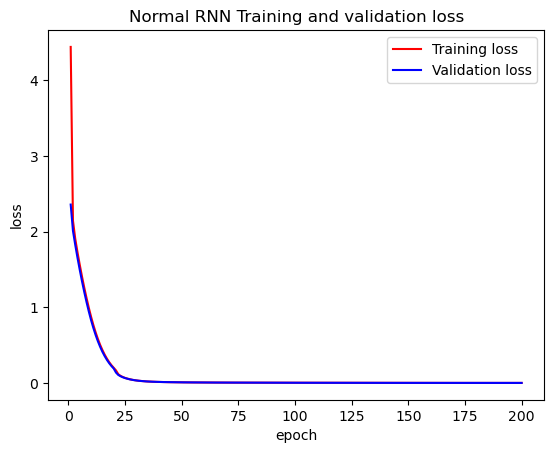

In [197]:
# plot training and validation losses against epochs

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Normal RNN Training and validation loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

C:\Users\zihaow19\AppData\Local\Temp\ipykernel_21164\151401212.py:12: RuntimeWarning: invalid value encountered in sqrt
  sqrt = np.sqrt(-2688000 * i**2 + 15772800000)


116/116 [==============================] - 14s 61ms/step
(3706, 10, 2)


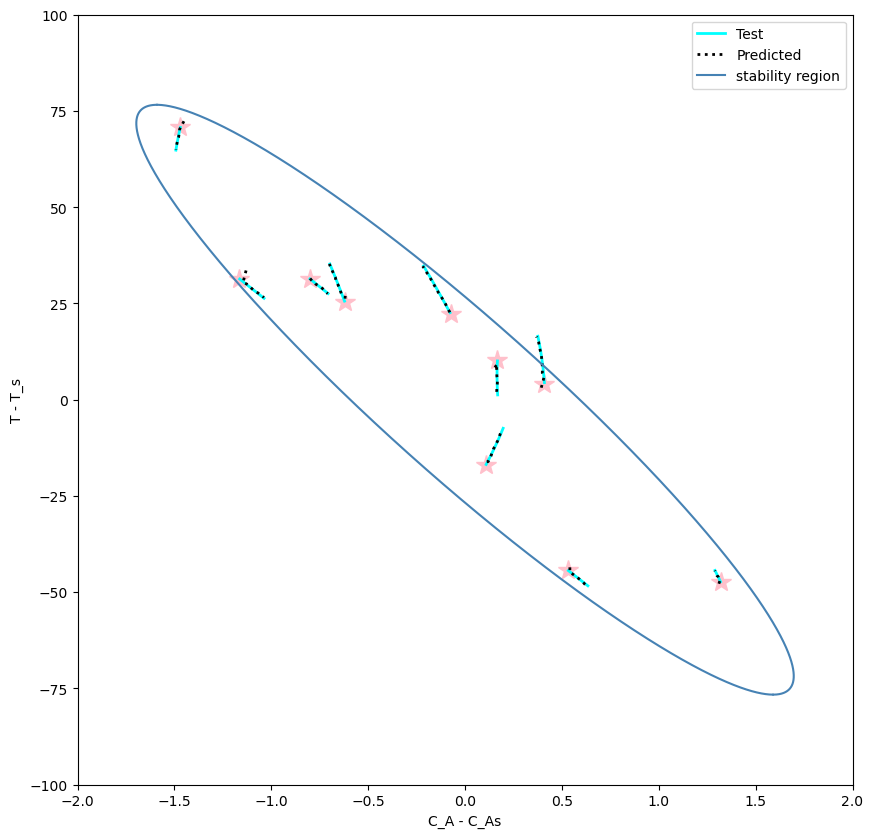

In [198]:
"""
    equation for the stability ellipse is 1060x^2 + 44xy + 0.52y^2 - 372 = 0
"""
# prepare x and y coordinates for plotting the stability region
y = np.linspace(-100, 100, 100000, endpoint=True)

x_upper = list()
x_lower = list()
y_plot = list()

for i in y:
    sqrt = np.sqrt(-2688000 * i**2 + 15772800000)
    if sqrt >= 0:
        y_plot.append(i)
        x_upper.append((-4400 * i + sqrt) / 212000)
        x_lower.append((-4400 * i - sqrt) / 212000)
        pass
    pass

plt.figure(figsize=(10,10))

# # plot the first 10 samples and their trajectories
y_predict = model.predict(X_test)
print(y_predict.shape)

y_predict = y_predict.reshape(-1,2)
y_predict = scaler_y.inverse_transform(y_predict)
y_predict = y_predict.reshape(-1,num_step,2)

X_plot = X_test.reshape(-1,num_dims)
X_plot = scaler_X.inverse_transform(X_plot)
X_plot = X_plot.reshape(-1,num_step,num_dims)

for i in range(10):
    if i == 0:  # only add label to 1 data point
        plt.plot(X_plot[i, 0, 1], X_plot[i, 0, 0], marker="*", markersize=15, color='pink')
        plt.plot(y_test[i, :, 1], y_test[i, :, 0], color='cyan', lw=2, label='Test')
        plt.plot(y_predict[i, :, 1], y_predict[i, :, 0], color='black', lw=2, ls=':', label='Predicted')
    else:
        plt.plot(X_plot[i, 0, 1], X_plot[i, 0, 0], marker="*", markersize=15, color='pink')
        plt.plot(y_test[i, :, 1], y_test[i, :, 0], color='cyan', lw=2)
        plt.plot(y_predict[i, :, 1], y_predict[i, :, 0], color='black', lw=2, ls=':')

# plot stability region
plt.plot(x_lower, y_plot, color='steelblue', label='stability region')
plt.plot(x_upper, y_plot, color='steelblue')
plt.ylim([-100, 100])
plt.xlim([-2, 2])

plt.xlabel("C_A - C_As")
plt.ylabel("T - T_s")
plt.legend()
# plt.savefig('iclrnn_noise_0.4.pdf')
plt.show()